In [1]:
#Control time packages
import time
import os
from autolens.plot.fit_imaging_plots import model_image

from numpy.core import machar
os.environ["OMP_NUM_THREADS"] = "1"

import autolens as al
import autolens.plot as aplt
import numpy as np

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

from schwimmbad import MPIPool

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Autolens/ALMA/Data"#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition

boundary = {'ml': [0.5, 15], 'kappa_s': [0, 2], 'r_s': [5, 30], 'qDM': [0.1, 1], 'log_mbh':[7, 11],
                    'mag_shear': [0, 0.1], 'phi_shear': [0, 179], 'gamma': [0.95, 1.05]}

class Model(object):

    def __init__(self, mass_model, masked_image):
        self.mass_profile  = mass_model
        self.masked_image = masked_image

    def prior_transform(self, theta):
        ml, kappa_s, qDM, r_s, log_mbh, mag_shear, phi_shear, gamma = theta
        parsDic = {"ml": ml, "kappa_s": kappa_s, "r_s": r_s, "qDM": qDM,
                        "log_mbh":log_mbh, "mag_shear": mag_shear, "phi_shear": phi_shear, 
                        "gamma": gamma}
        for key in parsDic:
            parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
            
        return np.array(list(parsDic.values()))

    def log_likelihood(self, pars):
        quiet=True
        ml_model, kappa_s_model, r_s_model, qDM_model, log_mbh_model, mag_shear_model, phi_shear_model, gamma_model = pars
        
        ell_comps = al.convert.elliptical_comps_from(axis_ratio=qDM_model, phi=0.0) #Elliptical components in Pyautolens units
        eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s_model,elliptical_comps=ell_comps, scale_radius=r_s_model) #Set the analytical model
        self.mass_profile.Analytic_Model(eNFW)        #Include analytical model
        self.mass_profile.MGE_Updt_parameters(ml=ml_model, mbh=10**log_mbh_model, gamma=gamma_model)
        shear_comp_model = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_model, phi=phi_shear_model)
        #New lens model
        lens_galaxy = al.Galaxy(                                            
                redshift=self.mass_profile.z_l,
                mass=self.mass_profile,
                shear=al.mp.ExternalShear(elliptical_comps=shear_comp_model),
            )

        source_galaxy = al.Galaxy(
                redshift=self.mass_profile.z_s,
                pixelization=al.pix.Rectangular(shape=(40, 40)),
                regularization=al.reg.Constant(coefficient=1.5),
            )
        tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
        
        try:
            fit = al.FitImaging(masked_imaging=self.masked_image, tracer=tracer)

            log_evidence = fit.log_evidence

                
            if quiet is False:
                print("Lens Galaxy Configuration:")
                print("Log Likelihood_with_regularization:", fit.log_likelihood)
                print("Log Normalization", fit.log_likelihood)
                print("Log Evidence:", fit.log_evidence)
                print("#------------------------------------#")
                print(lens_galaxy)
                print("\n")


                aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))
                aplt.Inversion.reconstruction(fit.inversion)              


            return log_evidence
        except:
            print("An exception ocurres in Pyautolens_log_likelihood().")
            return -np.inf
    
    def __call__(self, pars):
        return self.log_likelihood(pars)

def resume_dlogz(sampler):
        results = sampler.results
        logz_remain = np.max(sampler.live_logl) + results.logvol[-1]
        delta_logz = np.logaddexp(results.logz[-1], logz_remain) - results.logz[-1]
        
        return delta_logz

In [2]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.042                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

#Autolens Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/Alma_with_lens_center.fits",
        noise_map_path=f"{data_folder}/rms_noise_map.fits",
        psf_path=f"{data_folder}/Alma_psf_rot.fits",
        pixel_scales=0.01,
        image_hdu=1, noise_map_hdu=1, psf_hdu=1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/mask2.fits", 
                                pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)   #Masked image
#aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

#--------------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------------#
# PYAUTOLENS MODEL
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()
ell_comps = al.convert.elliptical_comps_from(axis_ratio=0.85, phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW


#Components

mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                    surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                    mbh=mbh)
mass_profile.Analytic_Model(analytic_profile=eNFW)



#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.50),
)

print("Starting functions... \n")
start = time.time()
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

#aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True,critical_curves=False,caustics=False))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)
print("Log Evidence:", fit.log_evidence)
print("Log Likelihood :", fit.log_likelihood)
print("Elapsed Time [s]:", (time.time() - start))

#Defing Model
#model = Model(mass_model=mass_profile, masked_image=masked_image)

Starting functions... 

Log Likelihood with Regularization: -392849.9461405418
Log Evidence: -396456.59798958234
Log Likelihood : -392849.9456722626
Elapsed Time [s]: 11.760928630828857


In [3]:
import pickle
with open(f'dynesty_lens.pickle','rb') as f:
    sample_load = pickle.load(f)
    
results = sample_load.results

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


(<Figure size 1152x1152 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c8b3a6cd0>,
       dtype=object))

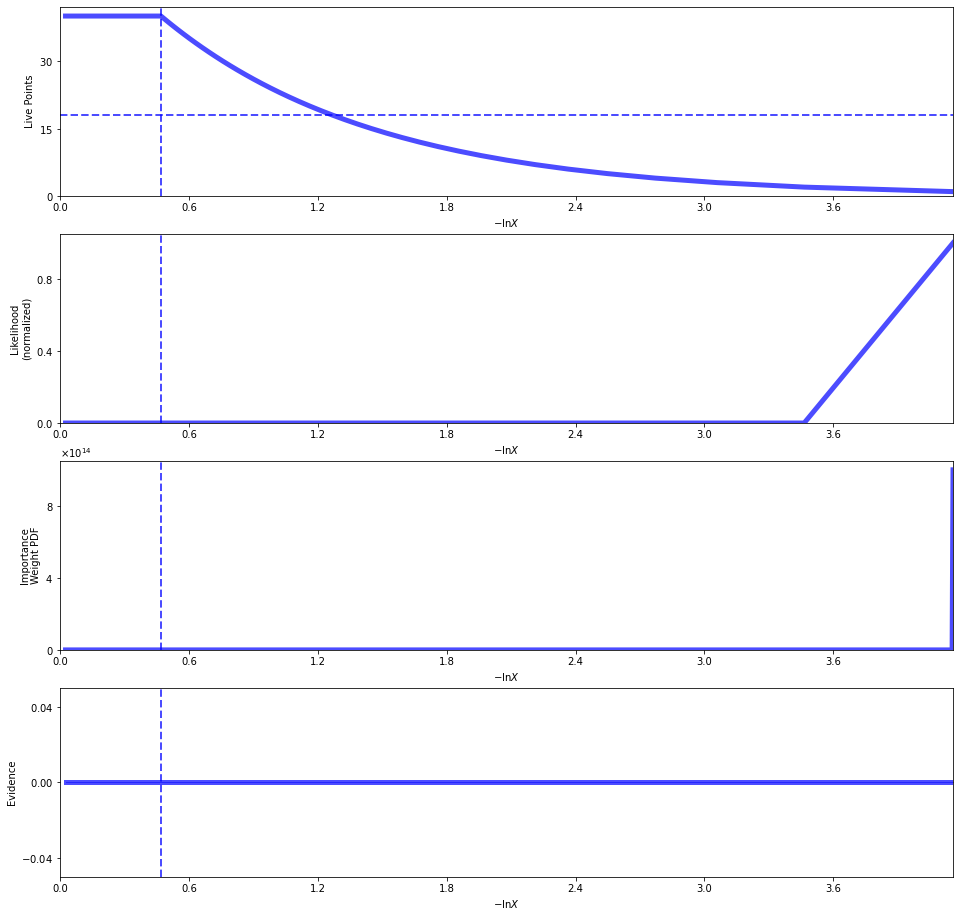

In [4]:
from dynesty import plotting as dyplot
dyplot.runplot(results)

In [5]:
from dynesty import utils as dyfunc
labels = ["ml", "kappa_s", "rs","qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(results)


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean, cov

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  cov = wsum / (wsum**2 - w2sum) * np.einsum('i,ij,ik', weights, dx, dx)
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:111: RuntimeWarning: invalid value encountered in multiply
  cov = wsum / (wsum**2 - w2sum) * np.einsum('i,ij,ik', weights, dx, dx)


(array([1.14012410e+00, 4.32718220e-02, 1.01164875e+01, 4.92592689e-01,
        1.07410749e+01, 2.52831959e-03, 1.70408051e+02, 1.02700436e+00]),
 array([[nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan]]))

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:225: RuntimeWarning: invalid value encountered in true_divide
  cdf /= cdf[-1]  # normalize CDF
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:1239: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(n) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:2166: RuntimeWarning: invalid value encountered in true_divide
  sm /= sm[-1]
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:2170: RuntimeWarning: invalid value encountered in less_equal
  V[i] = Hflat[sm <= v0][-1]


KeyboardInterrupt: 

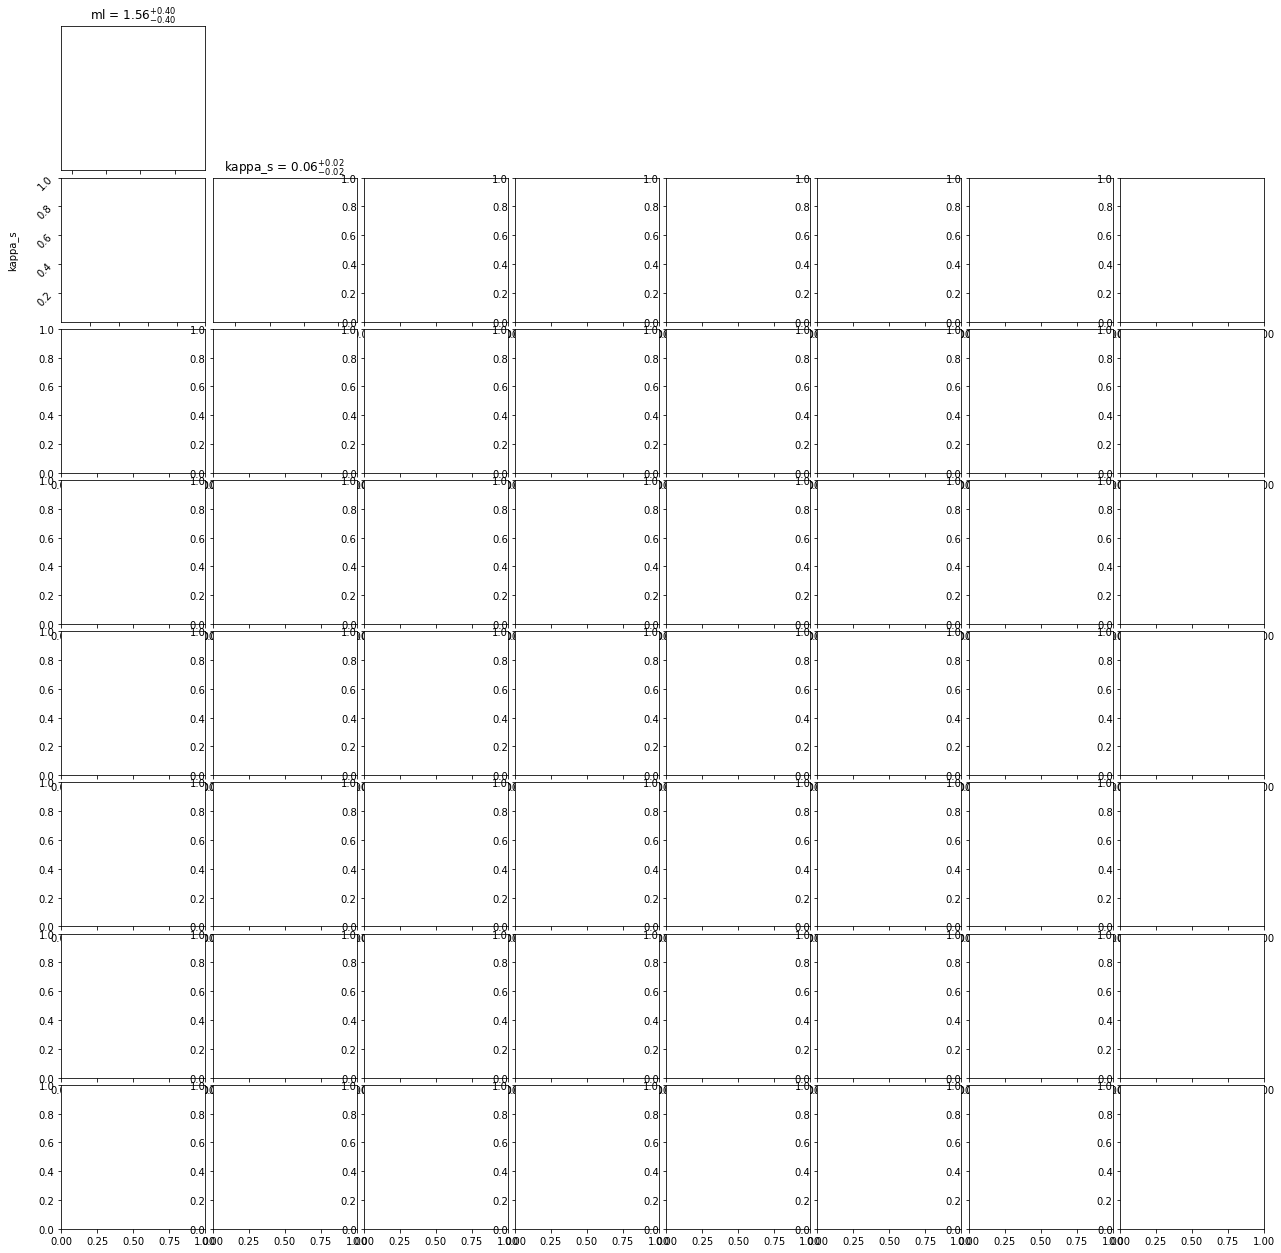

In [18]:
labels = ["ml", "kappa_s", "rs", "qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]
cfig, caxes = dyplot.cornerplot(results_sim, quantiles=None,show_titles=True,labels=labels,
                               )

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynes

NameError: name 'plt' is not defined

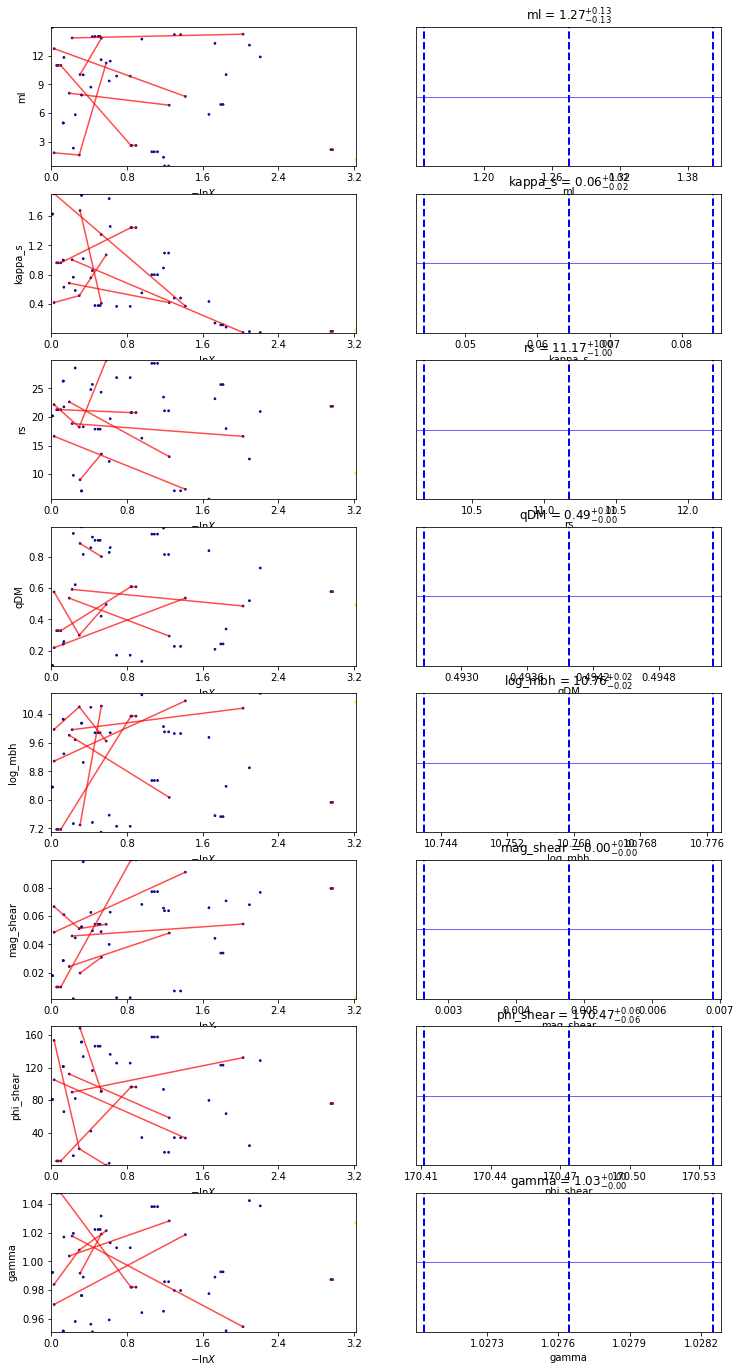

In [6]:
rfig, raxes = dyplot.traceplot(results_sim, labels=labels,kde=None, 
                               show_titles=True, connect=True, )
plt.tight_layout()